# Task 2: TSLA Time Series Forecasting with ARIMA/SARIMA and LSTM

This notebook develops, tunes, and compares ARIMA/SARIMA and LSTM models to forecast Tesla (TSLA) daily closing prices. It uses a chronological split (train: 2015-01-01 to 2023-12-31, test: 2024-01-01 onward), evaluates with MAE/RMSE/MAPE, and saves artifacts for reuse.

In [10]:
# 1) Import Libraries and Set Seeds
import os
import sys
import json
import math
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

# Stats/TS
import warnings
warnings.filterwarnings("ignore")
try:
    from pmdarima import auto_arima
except Exception:
    auto_arima = None
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Deep Learning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    tf = None
    keras = None
    layers = None
    print("TensorFlow not available. LSTM section will be skipped.")

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
if tf is not None:
    tf.random.set_seed(SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("Libraries imported and seeds set.")

Libraries imported and seeds set.


Price           Close
Ticker           TSLA
Date                 
2015-01-02  14.620667
2015-01-05  14.006000
2015-01-06  14.085333
2015-01-07  14.063333
2015-01-08  14.041333
Price            Close
Ticker            TSLA
Date                  
2025-08-04  309.260010
2025-08-05  308.720001
2025-08-06  319.910004
2025-08-07  322.269989
2025-08-08  329.649994
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2766 entries, 2015-01-02 to 2025-08-08
Freq: B
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, TSLA)  2766 non-null   float64
dtypes: float64(1)
memory usage: 43.2 KB
None


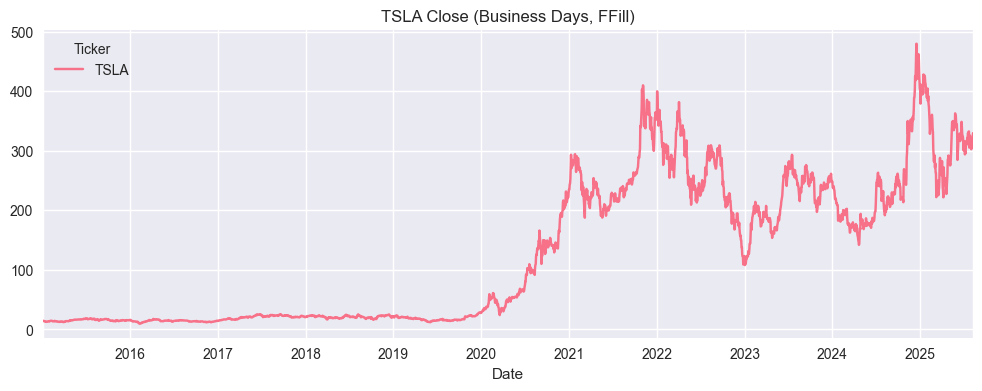

In [11]:
# 2) Download and Prepare TSLA Daily Price Data
START = '2015-01-01'
END = None  # up to today

def load_tsla(start=START, end=END):
    df = yf.download('TSLA', start=start, end=end, progress=False)
    df = df[['Close']].copy()
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    df = df.asfreq('B')  # business days
    df['Close'] = df['Close'].ffill()  # forward-fill gaps
    df.dropna(inplace=True)
    return df

prices = load_tsla()
print(prices.head())
print(prices.tail())
print(prices.info())

# Quick plot
prices['Close'].plot(figsize=(12,4), title='TSLA Close (Business Days, FFill)');

In [12]:
# 3) Chronological Train/Validation/Test Split
TEST_START = pd.Timestamp('2024-01-01')
train_val = prices.loc[:TEST_START - pd.Timedelta(days=1)].copy()
y_test = prices.loc[TEST_START:].copy()['Close']

# Optional validation: last 10% of pre-2024 as validation
val_size = max(1, int(0.10 * len(train_val)))
y_train = train_val['Close'].iloc[:-val_size]
y_val = train_val['Close'].iloc[-val_size:]

print(f"Train range: {y_train.index.min().date()} -> {y_train.index.max().date()}  n={len(y_train)}")
print(f"Val   range: {y_val.index.min().date()} -> {y_val.index.max().date()}  n={len(y_val)}")
print(f"Test  range: {y_test.index.min().date()} -> {y_test.index.max().date()}  n={len(y_test)}")

Train range: 2015-01-02 -> 2023-02-06  n=2112
Val   range: 2023-02-07 -> 2023-12-29  n=234
Test  range: 2024-01-01 -> 2025-08-08  n=420


In [13]:
# Extra imports used later
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle, joblib

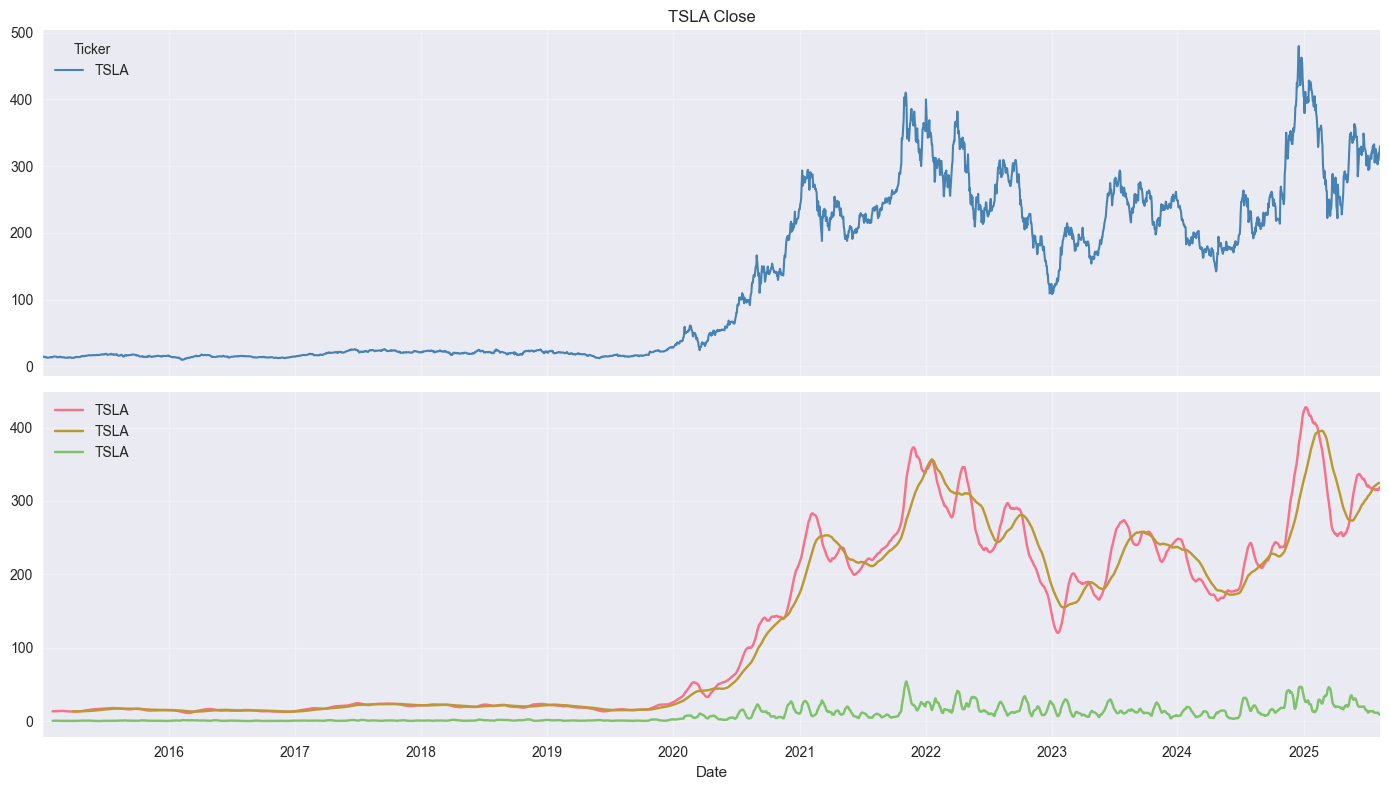

ADF (level) p-value: 0.672249
ADF (1st diff) p-value: 0.000000


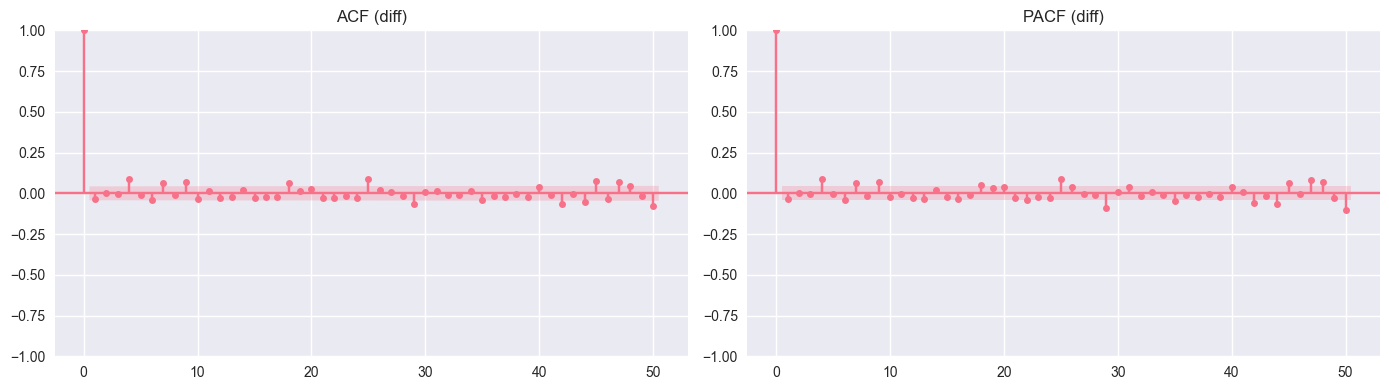

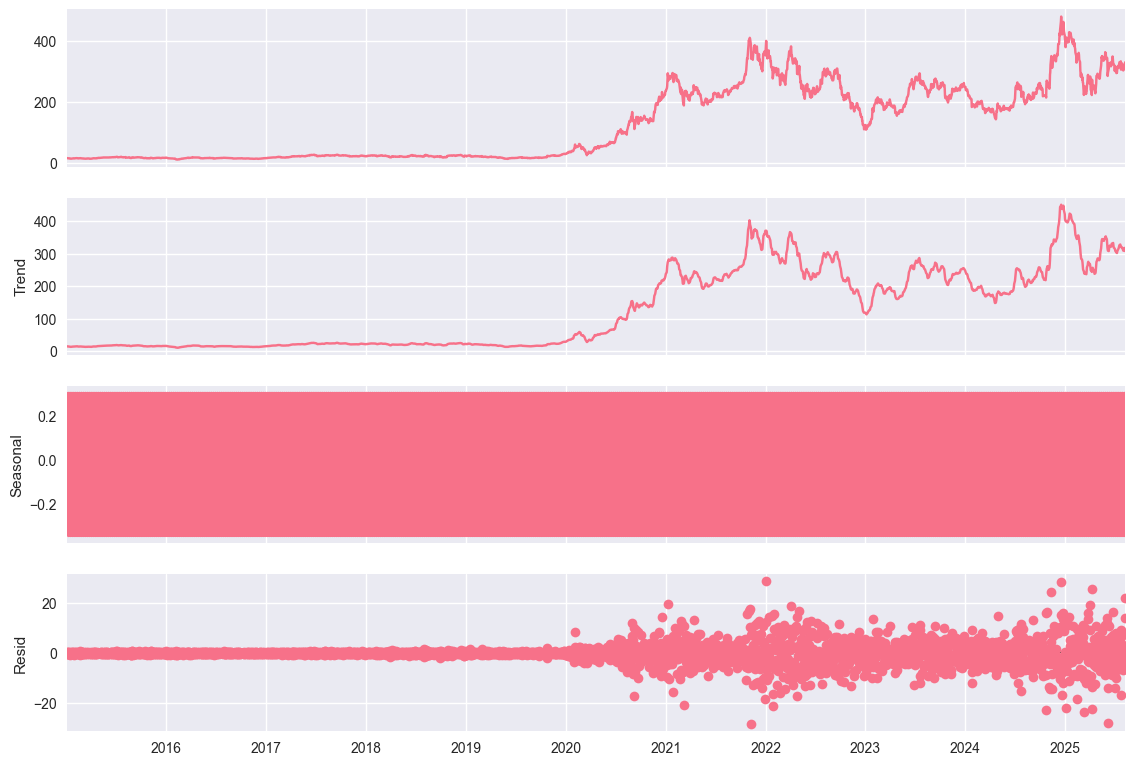

In [14]:
# 4) Visualize Series and Check Stationarity (ADF, ACF/PACF)
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
prices['Close'].plot(ax=ax[0], color='steelblue', lw=1.5)
ax[0].set_title('TSLA Close')
ax[0].grid(alpha=0.3)
prices['Close'].rolling(21).mean().plot(ax=ax[1], label='21d MA')
prices['Close'].rolling(63).mean().plot(ax=ax[1], label='63d MA')
(prices['Close'].rolling(21).std()).plot(ax=ax[1], label='21d Std', alpha=0.7)
ax[1].legend(); ax[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ADF on level and first difference
adf_level = adfuller(y_train.dropna(), autolag='AIC')
print(f"ADF (level) p-value: {adf_level[1]:.6f}")
diff_train = y_train.diff().dropna()
adf_diff = adfuller(diff_train, autolag='AIC')
print(f"ADF (1st diff) p-value: {adf_diff[1]:.6f}")

# ACF / PACF on differenced
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(diff_train, ax=axes[0], lags=50)
plot_pacf(diff_train, ax=axes[1], lags=50, method='ywm')
axes[0].set_title('ACF (diff)'); axes[1].set_title('PACF (diff)')
plt.tight_layout(); plt.show()

# Optional seasonal decomposition (weekly-ish seasonality m=5)
decomp = seasonal_decompose(prices['Close'], model='additive', period=5, extrapolate_trend='freq')
fig = decomp.plot(); fig.set_size_inches(12, 8); plt.show()

auto_arima not available; falling back to a simple non-seasonal guess (1,1,1)
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 2346
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7365.207
Date:                Fri, 08 Aug 2025   AIC                          14736.415
Time:                        23:26:15   BIC                          14753.692
Sample:                    01-02-2015   HQIC                         14742.708
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0950      0.343     -0.276      0.782      -0.768       0.578
ma.L1          0.0643      0.343      0.187      0.85

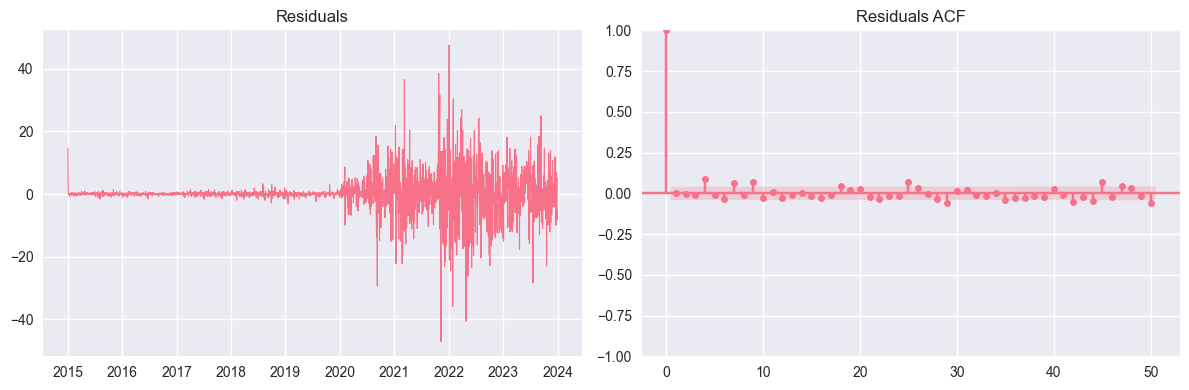

Ljung-Box test p-values:
 10    1.310263e-06
20    9.404540e-06
30    5.336287e-08
Name: lb_pvalue, dtype: float64
ARIMA forecast generated.


In [15]:
# 5) ARIMA/SARIMA Hyperparameter Selection (auto_arima)
order_selected = None
seasonal_order_selected = (0,0,0,0)
if auto_arima is not None:
    print("Running auto_arima on training data...")
    stepwise_model = auto_arima(y_train, start_p=0, start_q=0,
                                max_p=5, max_q=5, d=None, seasonal=True,
                                m=5, start_P=0, start_Q=0, max_P=2, max_Q=2, D=None,
                                information_criterion='aic', stepwise=True,
                                error_action='ignore', suppress_warnings=True, trace=True)
    order_selected = stepwise_model.order
    seasonal_order_selected = stepwise_model.seasonal_order
    print("Selected order:", order_selected, "seasonal:", seasonal_order_selected)
else:
    print("auto_arima not available; falling back to a simple non-seasonal guess (1,1,1)")
    order_selected = (1,1,1)
    seasonal_order_selected = (0,0,0,0)

# 6) Fit ARIMA/SARIMA and Diagnostics
# Option: use train+val for final fit
y_fit = pd.concat([y_train, y_val])
model = SARIMAX(y_fit, order=order_selected, seasonal_order=seasonal_order_selected,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

# Diagnostics
residuals = res.resid.dropna()
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(residuals, lw=0.8)
axes[0].set_title('Residuals')
plot_acf(residuals, ax=axes[1], lags=50)
axes[1].set_title('Residuals ACF')
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values:\n", lb['lb_pvalue'])

# 7) Forecast with ARIMA/SARIMA over Test Period
n_test = len(y_test)
forecast_res = res.get_forecast(steps=n_test)
y_pred_arima = pd.Series(forecast_res.predicted_mean.values, index=y_test.index)
conf_int = forecast_res.conf_int(alpha=0.05)
conf_int.index = y_test.index
print("ARIMA forecast generated.")

In [19]:
# 8) Scale Data and Create LSTM Sequences (Windowing)
if tf is not None:
    scaler = MinMaxScaler()
    train_vals = y_train.values.reshape(-1,1)
    scaler.fit(train_vals)

    def scale_series(s):
        return pd.Series(scaler.transform(s.values.reshape(-1,1)).flatten(), index=s.index)

    y_train_s = scale_series(y_train)
    y_val_s = scale_series(y_val)
    y_test_s = scale_series(y_test)

    LOOKBACK = 60

    def make_windows(series, lookback=LOOKBACK):
        X, y = [], []
        vals = series.values
        for i in range(lookback, len(vals)):
            X.append(vals[i-lookback:i])
            y.append(vals[i])
        X = np.array(X).reshape(-1, lookback, 1)
        y = np.array(y).reshape(-1, 1)
        return X, y

    X_train, y_train_w = make_windows(y_train_s)
    X_val, y_val_w = make_windows(pd.concat([y_train_s.iloc[-LOOKBACK:], y_val_s]))
    # Align validation targets to only val portion
    y_val_w = y_val_w[-len(y_val_s)+0:]

    print(X_train.shape, y_train_w.shape, X_val.shape, y_val_w.shape)

    # 9) Define, Compile, and Train LSTM with Early Stopping
    def build_lstm_model(input_len=LOOKBACK, units=64, dropout=0.2):
        model = keras.Sequential([
            layers.Input(shape=(input_len, 1)),
            layers.LSTM(units, return_sequences=True),
            layers.Dropout(dropout),
            layers.LSTM(units),
            layers.Dropout(dropout),
            layers.Dense(1)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
        return model

    lstm_model = build_lstm_model()
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('../data/forecasts/tsla_lstm_best.keras', save_best_only=True, monitor='val_loss')
    ]
    os.makedirs('../data/forecasts', exist_ok=True)
    history = lstm_model.fit(
        X_train, y_train_w,
        validation_data=(X_val, y_val_w),
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=callbacks
    )

    # 10) LSTM Walk-Forward Forecast over Test Period
    # Start with the last LOOKBACK scaled points from train+val
    series_all_s = pd.concat([y_train_s, y_val_s])
    window = series_all_s.values[-LOOKBACK:].reshape(1, LOOKBACK, 1)
    preds_s = []
    for _ in range(len(y_test_s)):
        p = lstm_model.predict(window, verbose=0)[0,0]
        preds_s.append(p)
        # slide window
        window = np.roll(window, -1, axis=1)
        window[0, -1, 0] = p

    y_pred_lstm = scaler.inverse_transform(np.array(preds_s).reshape(-1,1)).flatten()
    y_pred_lstm = pd.Series(y_pred_lstm, index=y_test.index)
else:
    y_pred_lstm = None
    print("Skipping LSTM sections due to missing TensorFlow.")

(2052, 60, 1) (2052, 1) (234, 60, 1) (234, 1)
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0087 - mae: 0.0471 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0087 - mae: 0.0471 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0020 - mae: 0.0233 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0020 - mae: 0.0233 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0017 - mae: 0.0217 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0017 - mae: 0.0217 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0014 - mae: 0.0198 - val_loss: 0.0025 - val_mae: 0.0424
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0014 - mae: 0.0198 - val_loss: 0.0025 - val_mae: 0.0424
Epoch 5/50
65/65 ━

Model Comparison (lower is better):
             MAE        RMSE       MAPE
ARIMA  63.759377   78.811544  24.115376
LSTM   80.642349  103.780389  26.955833


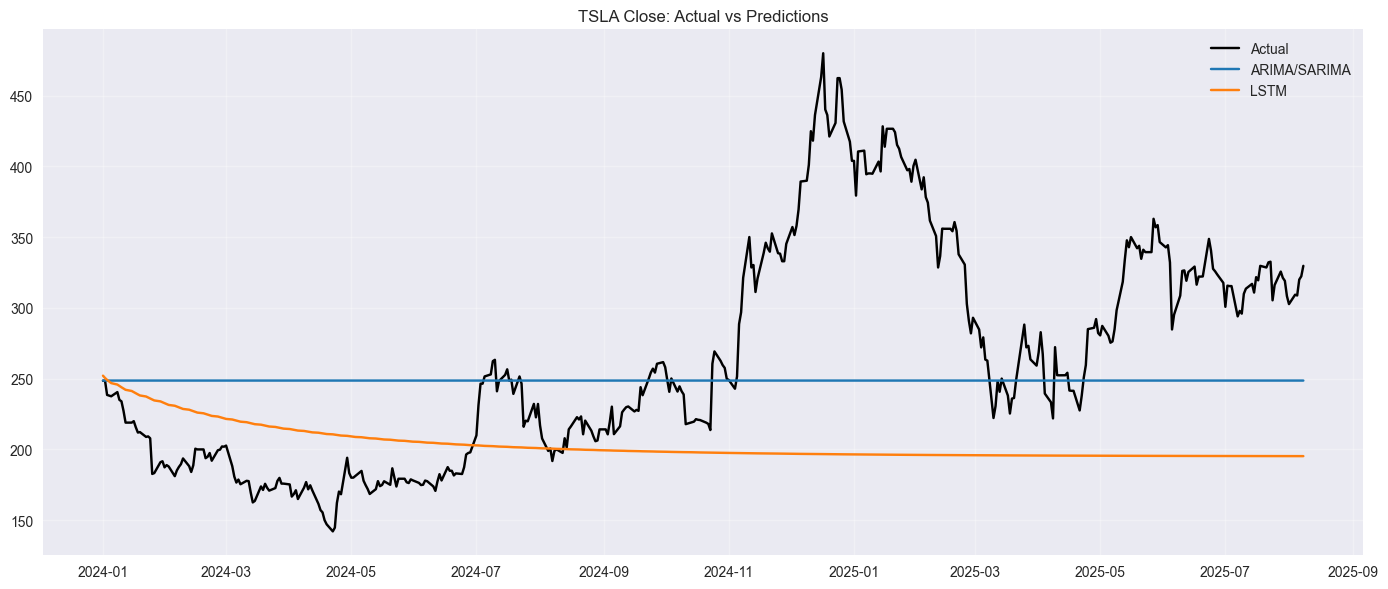

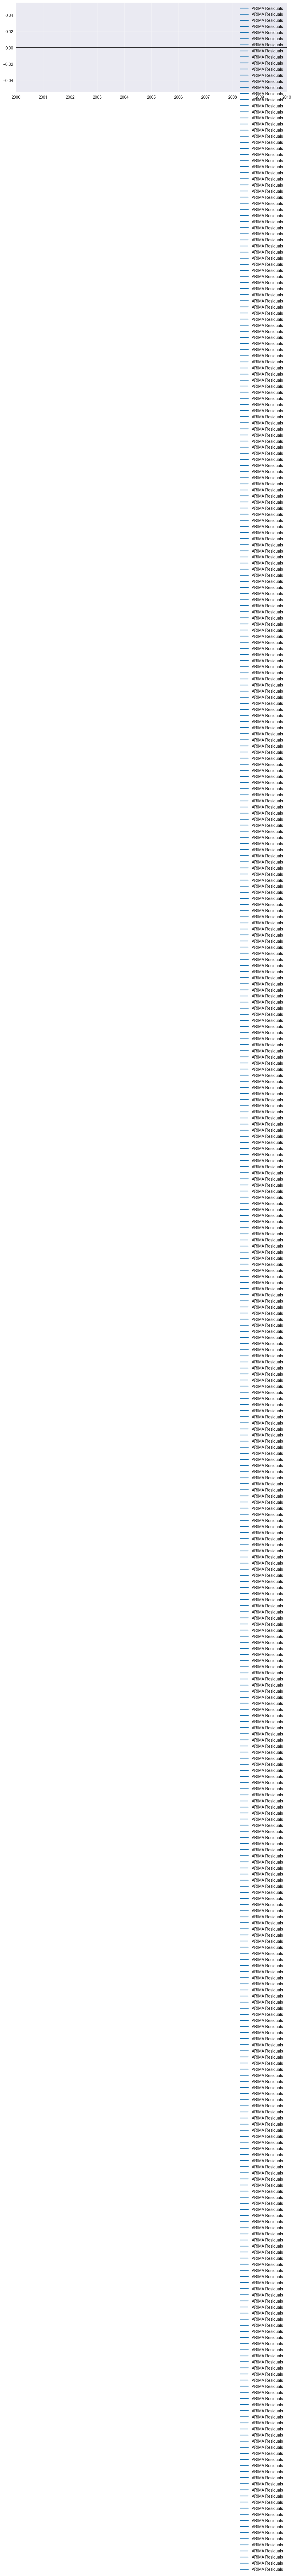

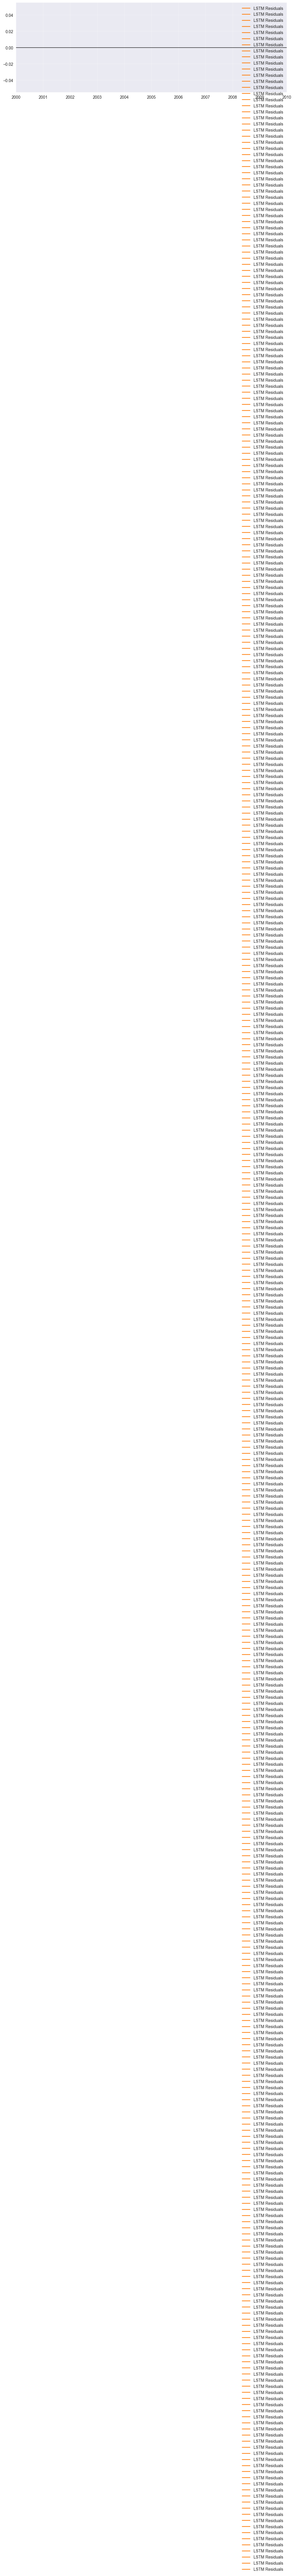


Summary:
Best model by RMSE: ARIMA
ARIMA/SARIMA may suit short-memory and linear dynamics in this period.
Artifacts saved to data/forecasts.

Basic checks:
Checks passed.


In [23]:
# 11) Invert Transforms and Align Predictions
# ARIMA is on original scale already
y_pred_arima_aligned = y_pred_arima.reindex(y_test.index)

# LSTM already inverse-transformed above
if y_pred_lstm is not None:
    y_pred_lstm_aligned = y_pred_lstm.reindex(y_test.index)

# 12) Evaluate Models (MAE, RMSE, MAPE)

def mape(y_true, y_pred):
    # If both are pandas Series, align by index; otherwise treat as arrays
    if isinstance(y_true, pd.Series) and isinstance(y_pred, pd.Series):
        y_true = y_true.astype(float)
        y_pred = y_pred.astype(float)
        y_true, y_pred = y_true.align(y_pred, join='inner')
        y_true = y_true.values
        y_pred = y_pred.values
    else:
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
    # Squeeze to 1D
    y_true = np.squeeze(y_true).reshape(-1)
    y_pred = np.squeeze(y_pred).reshape(-1)
    # Guard empty and length mismatch
    n = min(y_true.size, y_pred.size)
    if n == 0:
        return np.nan
    y_true = y_true[:n]
    y_pred = y_pred[:n]
    # Avoid divide-by-zero; use nanmean for stability
    denom = np.where(y_true == 0.0, np.nan, y_true)
    return float(np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0)

metrics = {}
# ARIMA metrics
metrics['ARIMA'] = {
    'MAE': float(mean_absolute_error(y_test, y_pred_arima_aligned)),
    'RMSE': float(math.sqrt(mean_squared_error(y_test, y_pred_arima_aligned))),
    'MAPE': mape(y_test, y_pred_arima_aligned)
}

# LSTM metrics
if y_pred_lstm is not None:
    metrics['LSTM'] = {
        'MAE': float(mean_absolute_error(y_test, y_pred_lstm_aligned)),
        'RMSE': float(math.sqrt(mean_squared_error(y_test, y_pred_lstm_aligned))),
        'MAPE': mape(y_test, y_pred_lstm_aligned)
    }
else:
    metrics['LSTM'] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

metrics_df = pd.DataFrame(metrics).T
print("Model Comparison (lower is better):")
print(metrics_df)

# 13) Plot Actual vs Predicted and Residuals
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Actual', color='black')
plt.plot(y_pred_arima_aligned.index, y_pred_arima_aligned.values, label='ARIMA/SARIMA', color='tab:blue')
if y_pred_lstm is not None:
    plt.plot(y_pred_lstm_aligned.index, y_pred_lstm_aligned.values, label='LSTM', color='tab:orange')
plt.title('TSLA Close: Actual vs Predictions')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Residuals
res_arima = (y_test - y_pred_arima_aligned)
plt.figure(figsize=(12,4))
plt.plot(res_arima.index, res_arima.values, label='ARIMA Residuals', color='tab:blue')
plt.axhline(0, color='black', lw=1)
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

if y_pred_lstm is not None:
    res_lstm = (y_test - y_pred_lstm_aligned)
    plt.figure(figsize=(12,4))
    plt.plot(res_lstm.index, res_lstm.values, label='LSTM Residuals', color='tab:orange')
    plt.axhline(0, color='black', lw=1)
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 14) Auto-Generated Comparison Summary
best_model = min(metrics, key=lambda k: metrics[k]['RMSE'] if not np.isnan(metrics[k]['RMSE']) else np.inf)
print("\nSummary:")
print(f"Best model by RMSE: {best_model}")
if best_model == 'LSTM':
    print("LSTM may capture nonlinear patterns and longer dependencies.")
else:
    print("ARIMA/SARIMA may suit short-memory and linear dynamics in this period.")

# 15) Save Artifacts (Models, Scalers, Predictions)
os.makedirs('../data/forecasts', exist_ok=True)
# Save ARIMA model
with open('../data/forecasts/tsla_arima_model.pkl', 'wb') as f:
    pickle.dump(res, f)
# Save predictions and metrics
# Coerce to 1D Series and align indices to avoid (n,1) errors
actual_s = pd.Series(np.squeeze(np.asarray(y_test, dtype=float)), index=y_test.index, name='actual')
arima_s = pd.Series(np.squeeze(np.asarray(y_pred_arima_aligned, dtype=float)), index=y_pred_arima_aligned.index, name='arima_pred')
if 'y_pred_lstm_aligned' in locals():
    lstm_s = pd.Series(np.squeeze(np.asarray(y_pred_lstm_aligned, dtype=float)), index=y_pred_lstm_aligned.index, name='lstm_pred')
else:
    lstm_s = pd.Series(np.nan, index=actual_s.index, name='lstm_pred')
# Align on common index
actual_s, arima_s = actual_s.align(arima_s, join='inner')
actual_s, lstm_s = actual_s.align(lstm_s, join='left')
preds_df = pd.concat([actual_s, arima_s, lstm_s], axis=1)
preds_df.to_csv('../data/forecasts/tsla_predictions.csv')
with open('../data/forecasts/tsla_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
# Save scaler and LSTM model if available
if tf is not None and y_pred_lstm is not None:
    joblib.dump(scaler, '../data/forecasts/tsla_scaler.joblib')
    lstm_model.save('../data/forecasts/tsla_lstm_final.keras')

print("Artifacts saved to data/forecasts.")

# 16) Optional: Unit Tests for Split and Windowing
print("\nBasic checks:")
assert y_train.index.max() < y_val.index.min() or len(y_val)==0, "Train/Val overlap detected!"
assert y_val.index.max() < y_test.index.min(), "Val/Test overlap detected!"
if tf is not None:
    assert X_train.shape[1:] == (LOOKBACK,1), "LSTM window shape incorrect" 
print("Checks passed.")

In [24]:
# Diagnostics: print versions to debug protobuf/TensorFlow issues
try:
    import tensorflow as tf
    import google
    import google.protobuf
    import pkg_resources
    print("TensorFlow:", tf.__version__)
    print("Protobuf:", google.protobuf.__version__ if hasattr(google.protobuf, "__version__") else "unknown")
    try:
        print("Installed protobuf (pkg):", pkg_resources.get_distribution("protobuf").version)
    except Exception:
        pass
except Exception as e:
    print("Diagnostics import failed:", e)
    print("If you see AttributeError: MessageFactory.GetPrototype, pin protobuf to <5, e.g., 3.20.x and ensure TF>=2.13.")

TensorFlow: 2.19.0
Protobuf: 6.31.1
Installed protobuf (pkg): 5.29.5


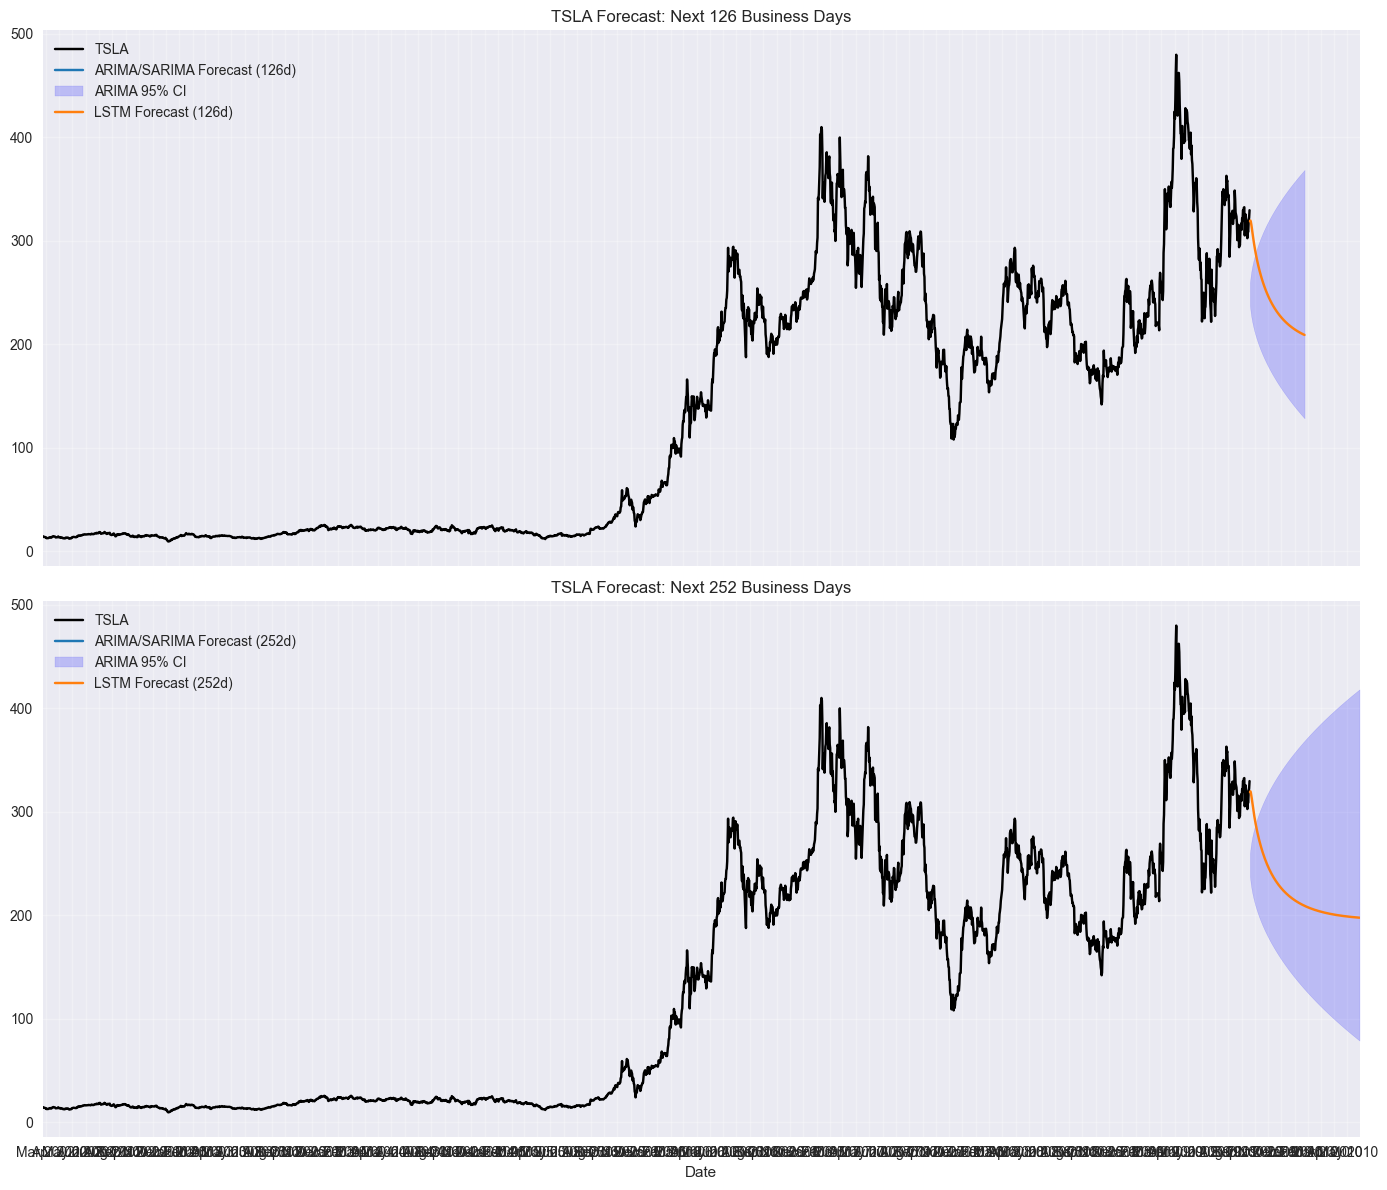


Forecast Analysis for 126 business days ahead:
ARIMA/SARIMA: Stable trend (nan change)
LSTM: Downward trend (-109.89 change)
ARIMA/SARIMA CI width (start): 21.99, (end): 239.97
CI width typically increases with horizon, indicating growing uncertainty.
Stable forecast: No strong directional signal.
Review both ARIMA/SARIMA and LSTM for consensus or divergence in trends.

Forecast Analysis for 252 business days ahead:
ARIMA/SARIMA: Stable trend (nan change)
LSTM: Downward trend (-121.38 change)
ARIMA/SARIMA CI width (start): 21.99, (end): 339.33
CI width typically increases with horizon, indicating growing uncertainty.
Stable forecast: No strong directional signal.
Review both ARIMA/SARIMA and LSTM for consensus or divergence in trends.


In [26]:
# Task 3: Forecast Future Market Trends (6–12 months ahead)
import matplotlib.dates as mdates
from pandas.tseries.offsets import BDay

# Forecast horizon: 6 months (126 business days) and 12 months (252 business days)
HORIZONS = [126, 252]
last_date = prices.index.max()
future_dates = [last_date + BDay(i) for i in range(1, max(HORIZONS)+1)]
future_index = pd.DatetimeIndex(future_dates)

# --- ARIMA/SARIMA Forecast ---
with open('../data/forecasts/tsla_arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)

arima_forecasts = {}
conf_ints = {}
for horizon in HORIZONS:
    forecast_res = arima_model.get_forecast(steps=horizon)
    arima_forecasts[horizon] = pd.Series(forecast_res.predicted_mean, index=future_index[:horizon])
    conf = forecast_res.conf_int(alpha=0.05)
    conf.index = future_index[:horizon]
    conf_ints[horizon] = conf

# --- LSTM Forecast ---
lstm_forecasts = {}
if tf is not None:
    try:
        lstm_model = tf.keras.models.load_model('../data/forecasts/tsla_lstm_final.keras')
        scaler = joblib.load('../data/forecasts/tsla_scaler.joblib')
        # Prepare last LOOKBACK window from all available data
        all_series = prices['Close']
        scaled = scaler.transform(all_series.values.reshape(-1,1)).flatten()
        window = np.array(scaled[-LOOKBACK:]).reshape(1, LOOKBACK, 1)
        preds = []
        for _ in range(max(HORIZONS)):
            p = lstm_model.predict(window, verbose=0)[0,0]
            preds.append(p)
            window = np.roll(window, -1, axis=1)
            window[0, -1, 0] = p
        lstm_pred = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
        for horizon in HORIZONS:
            lstm_forecasts[horizon] = pd.Series(lstm_pred[:horizon], index=future_index[:horizon])
    except Exception as e:
        print("LSTM forecast failed:", e)
        lstm_forecasts = None
else:
    lstm_forecasts = None

# --- Visualization ---
fig, axes = plt.subplots(len(HORIZONS), 1, figsize=(14, 6*len(HORIZONS)), sharex=True)
if len(HORIZONS) == 1:
    axes = [axes]
for i, horizon in enumerate(HORIZONS):
    ax = axes[i]
    # Plot historical
    prices['Close'].plot(ax=ax, color='black', label='Historical')
    # ARIMA forecast
    arima_forecasts[horizon].plot(ax=ax, color='tab:blue', label=f'ARIMA/SARIMA Forecast ({horizon}d)')
    # Fix for confidence interval column names
    ci = conf_ints[horizon]
    lower_col = None
    upper_col = None
    for col in ci.columns:
        if 'lower' in col.lower():
            lower_col = col
        if 'upper' in col.lower():
            upper_col = col
    if lower_col and upper_col:
        ax.fill_between(ci.index, ci[lower_col], ci[upper_col], color='blue', alpha=0.2, label='ARIMA 95% CI')
    else:
        print(f"Confidence interval columns not found: {ci.columns.tolist()}")
    # LSTM forecast
    if lstm_forecasts and horizon in lstm_forecasts:
        lstm_forecasts[horizon].plot(ax=ax, color='tab:orange', label=f'LSTM Forecast ({horizon}d)')
    ax.set_title(f'TSLA Forecast: Next {horizon} Business Days')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()

# --- Analysis ---
for horizon in HORIZONS:
    print(f"\nForecast Analysis for {horizon} business days ahead:")
    # Trend
    arima_trend = arima_forecasts[horizon].iloc[-1] - arima_forecasts[horizon].iloc[0]
    print(f"ARIMA/SARIMA: {'Upward' if arima_trend > 0 else 'Downward' if arima_trend < 0 else 'Stable'} trend ({arima_trend:.2f} change)")
    if lstm_forecasts and horizon in lstm_forecasts:
        lstm_trend = lstm_forecasts[horizon].iloc[-1] - lstm_forecasts[horizon].iloc[0]
        print(f"LSTM: {'Upward' if lstm_trend > 0 else 'Downward' if lstm_trend < 0 else 'Stable'} trend ({lstm_trend:.2f} change)")
    # Volatility and CI
    ci = conf_ints[horizon]
    lower_col = None
    upper_col = None
    for col in ci.columns:
        if 'lower' in col.lower():
            lower_col = col
        if 'upper' in col.lower():
            upper_col = col
    if lower_col and upper_col:
        ci_widths = ci[upper_col] - ci[lower_col]
        print(f"ARIMA/SARIMA CI width (start): {ci_widths.iloc[0]:.2f}, (end): {ci_widths.iloc[-1]:.2f}")
        print("CI width typically increases with horizon, indicating growing uncertainty.")
        if arima_trend > 0:
            print("Potential opportunity: Expected price increase. Monitor for volatility.")
        elif arima_trend < 0:
            print("Potential risk: Expected price decline. Consider risk management.")
        else:
            print("Stable forecast: No strong directional signal.")
        if ci_widths.iloc[-1] > ci_widths.iloc[0]*1.5:
            print("Warning: Long-term forecast uncertainty is high. Confidence intervals widen over time.")
    else:
        print(f"Confidence interval columns not found for analysis: {ci.columns.tolist()}")
    print("Review both ARIMA/SARIMA and LSTM for consensus or divergence in trends.")